# VARIATIONAL QUANTUM EIGENSOLVER FOR "LiH" MOLECULE 
    by Krishanu Podder (IBM QUANTUM CHALLENGE 2021)

    Variational Quantum Eigensolver (VQE), an algorithm meant for finding the ground state energy(lowest energy)of a molecule, with much shallower circuits than other approaches. VQE's magic comes from outsourcing some of the problem's processing    workload to a classical computer. The algorithm starts with a parameterized quantum circuit called an ansatz (a best guess) then finds the optimal parameters for this circuit using a classical optimizer. 
    The VQE's advantage over classical algorithms comes from the fact that a quantum processing unit can represent and store   the problem's exact wavefunction, an exponentially hard problem for a classical computer. 
    This Project helps to realize Feynman's dream, setting up a variational quantum eigensolver to determine the ground state and the energy of a molecule. This is interesting because the ground state can be used to calculate various molecular properties, for instance the exact forces on nuclei that can serve to run molecular dynamics simulations to explore what happens in chemical systems with time.

1. DRIVER

    The interfaces to the classical chemistry codes that are available in Qiskit are called drivers. We have for example PSI4Driver, PyQuanteDriver, PySCFDriver are available. By running a driver (Hartree-Fock calculation for a given basis set and molecular geometry), in the cell below, we obtain all the necessary information about our molecule to apply then a quantum algorithm.

In [13]:
from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit.aqua.operators import Z2Symmetries
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()

2. ELECTRONIC STRUCTURE PROBLEM

    An ElectronicStructureProblem is created that can produce the list of fermionic operators before mapping them to qubits (Pauli strings). Here, freeze core is used and we have removed orbitals.

In [14]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
transformer = FreezeCoreTransformer()
qmolecule = transformer.transform(qmolecule)
problem = ElectronicStructureProblem(driver ,q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True,
                                                                                            remove_orbitals=[3,4])])



# Generating the second-quantized operators
second_q_ops = problem.second_q_ops()
# Hamiltonian
main_op = second_q_ops[0]

3. QUBIT_CONVERTER

    It allows to define the mapping that we will use in the simulation. We can try different mapping but we will stick to ParityMapper. Besides we will use z2symmetry.

In [15]:
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup the mapper and qubit converter
mapper = ParityMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True , z2symmetry_reduction=[1,1])

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,problem.molecule_data_transformed.num_beta)
num_particle = qmolecule.num_alpha + qmolecule.num_beta

qubit_op = converter.convert(main_op, num_particles=num_particles)

4. INITIAL STATE

    Here we will initialize the Initial State

In [16]:
from qiskit_nature.circuit.library import HartreeFock
num_particles = (problem.molecule_data_transformed.num_alpha,problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


5. ANSATZ

    One of the most important choices is the quantum circuit that we choose to approximate our ground state. We will choose TwoLocal ansatz and play with its various parameters. The 5 most important parameters of TwoLocal to play around are:
    a. rotational_blocks, 
    b. entanglement_blocks, 
    c. entanglement, 
    d. repetitions, 
    e. skip_final_rotation_layer

        ┌───┐    ┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐»
q_0: ───┤ X ├────┤ RY(θ[0]) ├┤ RZ(θ[4]) ├──■──┤ RY(θ[8]) ├┤ RZ(θ[12]) ├»
        ├───┤    ├──────────┤├──────────┤┌─┴─┐└──────────┘└┬──────────┤»
q_1: ───┤ X ├────┤ RY(θ[1]) ├┤ RZ(θ[5]) ├┤ X ├─────■───────┤ RY(θ[9]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘└───┘   ┌─┴─┐     └──────────┘»
q_2: ┤ RY(θ[2]) ├┤ RZ(θ[6]) ├────────────────────┤ X ├──────────■──────»
     ├──────────┤├──────────┤                    └───┘        ┌─┴─┐    »
q_3: ┤ RY(θ[3]) ├┤ RZ(θ[7]) ├─────────────────────────────────┤ X ├────»
     └──────────┘└──────────┘                                 └───┘    »
«                               
«q_0: ──────────────────────────
«     ┌───────────┐             
«q_1: ┤ RZ(θ[13]) ├─────────────
«     ├───────────┤┌───────────┐
«q_2: ┤ RY(θ[10]) ├┤ RZ(θ[14]) ├
«     ├───────────┤├───────────┤
«q_3: ┤ RY(θ[11]) ├┤ RZ(θ[15]) ├
«     └───────────┘└───────────┘


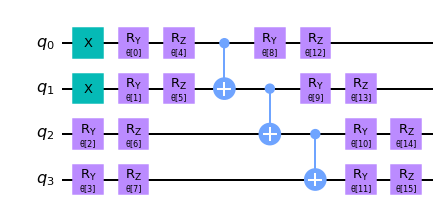

In [17]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD

# Choosing the ansatz
ansatz_type = "TwoLocal"

# Parameters for q-UCC ansatz
num_particles = (problem.molecule_data_transformed.num_alpha,problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# Putting arguments for twolocal
if ansatz_type == "TwoLocal":
    # Single qubit rotations that are placed on all qubits with independent parameters
    rotation_blocks = ['ry', 'rz']
    # Entangling gates
    entanglement_blocks = 'cx'
    # How the qubits are entangled?
    entanglement = 'linear'
    # Repetitions of rotation_blocks + entanglement_blocks with independent parameters
    repetitions = 1
    # Skipoing the final rotation_blocks layer
    skip_final_rotation_layer = False
    ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks,
        reps=repetitions, entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)
    
elif ansatz_type == "UCCSD":    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "PUCCD":    ansatz = PUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "SUCCD":    ansatz = SUCCD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
elif ansatz_type == "Custom":
    # Example of how to write own circuit
    from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister
    # Define the variational parameter
    theta = Parameter('a')
    n = qubit_op.num_qubits
    # Make an empty quantum circuit
    qc = QuantumCircuit(qubit_op.num_qubits)
    qubit_label = 0
    # Place a Hadamard gate
    qc.h(qubit_label)
    # Place a CNOT ladder
    for i in range(n-1):
        qc.cx(i, i+1)
    # Visual separator
    #qc.barrier()
    # rz rotations on all qubits
    qc.rz(theta, range(n))
    ansatz = qc
    ansatz.compose(init_state, front=True, inplace=True)
print(ansatz)
ansatz.draw(output="mpl")

6. BACKEND

    This is where we specify the simulator or device where we want to run our algorithm. We will focus on the statevector_simulator in this Project

In [18]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

7. OPTIMIZER

    The optimizer guides the evolution of the parameters of the ansatz so it is very important to investigate the energy convergence as it would define the number of measurements that have to be performed on the QPU. A clever choice might reduce drastically the number of needed energy evaluations.
    Here, we will use COBYLA with 10000 iterations.

In [19]:
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP

optimizer_type = 'COBYLA'

if optimizer_type == 'COBYLA': optimizer = COBYLA(maxiter=10000)
elif optimizer_type == 'L_BFGS_B': optimizer = L_BFGS_B(maxfun=50000)
elif optimizer_type == 'SPSA': optimizer = SPSA(maxiter=500)
elif optimizer_type == 'SLSQP': optimizer = SLSQP(maxiter=500)

8. EXACT EIGENSOLVER

    For learning purposes, we can solve the problem exactly with the exact diagonalization of the Hamiltonian matrix so we know where to aim with VQE. Of course, the dimensions of this matrix scale exponentially in the number of molecular orbitals so we can try doing this for a large molecule of our choice and see how slow this becomes. For very large systems we would run out of memory trying to store their wavefunctions.

In [20]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy:", exact_energy)
print("Result exact:",result_exact)
# The targeted electronic energy for LiH is -1.85336 Ha

Exact electronic energy: -1.088706015734742
Result exact: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


9. VQE AND INITIAL PARAMETERS FOR THE ANSATZ

    Now we will import the VQE class and run the algorithm.

In [21]:
from qiskit.algorithms import VQE
from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
counts = []
values = []
params = []
deviation = []
# Set initial parameters of the ansatz
# We choose a fixed small displacement

try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters
algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)
result = algorithm.compute_minimum_eigenvalue(qubit_op)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 10000,
    'eigenstate': array([-1.83580778e-05+1.55820068e-03j, -2.43930437e-03-3.20874757e-03j,
        8.86392197e-03+6.17021070e-03j,  1.23585080e-01-9.84146319e-01j,
        6.91385721e-03-5.26747082e-02j,  3.41678460e-04-4.48323598e-04j,
        1.46803989e-06+2.71852025e-04j,  3.90005952e-03-1.97857408e-02j,
        1.45902635e-04-2.45444356e-03j,  1.76025678e-05-1.77406469e-05j,
       -1.08365599e-05+4.91281791e-06j, -1.57846535e-06+3.59166212e-04j,
       -1.37273274e-02+1.12307491e-01j, -8.23458933e-04+8.06388692e-04j,
        3.85840466e-04-2.71738240e-04j,  2.08391728e-04-2.95782881e-03j]),
    'eigenvalue': -1.0862643058659451,
    'optimal_parameters': {   ParameterVectorElement(θ[9]): -0.008134328867821925,
                              ParameterVectorElement(θ[8]): 3.163353523181121,
                              ParameterVectorElement(θ[7]): 0.00015665505355855092,
                              Parameter

9. SCORING FUNCTION

    This is a simple scoring function to judge how good are our VQE simulations, our choice of ansatz/optimizer:
        score=NCNOT 

    where  NCNOT  is the number of CNOTs. We have to reach the chemical accuracy which is  δEchem=0.004Ha  = 4mHa, which may be hard to reach depending on the problem. We have to reach the accuracy in a minimal number of CNOTs. The lower the score the better.

,optimizer,ansatz,# of qubits,error (mHa),pass,score,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions
0,COBYLA,TwoLocal,4,2.44171,True,3,16,"[ry, rz]",cx,linear,1


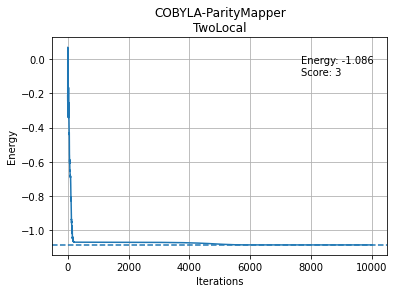

In [22]:
# Storing results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
# Unroller transpile our circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots
accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value
if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': rotation_blocks,
        'entanglement_blocks': entanglement_blocks,
        'entanglement': entanglement,
        'repetitions': repetitions,
        'skip_final_rotation_layer': skip_final_rotation_layer,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
# Plotting the results
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)
# Displaying and saving the data
import pandas as pd
result_df = pd.DataFrame.from_dict([result_dict])
result_df[['optimizer','ansatz', '# of qubits', 'error (mHa)', 'pass', 'score','# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions']]

    - NAME : KRISHANU PODDER (https://www.linkedin.com/in/krishanu-podder-905a9a89/)
    - SCORE: 3
    - RANK : 1ST
    - CHEMICAL ACCURACY: 97.60% 
    - NUMBER OF PARAMETERS IN THE ANSATZ: 16
    - OPTIMIZER USED: COBYLA (EVALUATION: 10000)
    - ANSATZ : TwoLocal
    - NUMBER OF QUBITS: 4
    - ERROR(mHa): 2.451258
    - ROTATION BLOCKS: ry,rz
    - ENTANGLEMENT BLOCKS: cx
    - ENTANGLEMENT: LINEAR
    - REPETITIONS: 1
    - freeze_core = True


Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 3.

# IBM QUANTUM CHALLENGE 2021